In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklego.metrics import equal_opportunity_score
from sklego.metrics import p_percent_score
from sklearn.metrics import log_loss
from sklearn.utils.extmath import squared_norm
from moopt.scalarization_interface import scalar_interface, single_interface, w_interface
from moopt import monise
import numpy as np
import optuna, sklearn, sklearn.datasets
from fair_models import coefficient_of_variation, MOOLogisticRegression, FairScalarization, EqualScalarization

import matplotlib.pyplot as plt

import sklearn
from scipy import stats
import math


#import DES techniques from DESlib
from deslib.des.des_p import DESP
from deslib.des.knora_u import KNORAU
from deslib.des.knora_e import KNORAE
from deslib.des.meta_des import METADES

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
class SimpleVoting():
    def __init__(self, estimators, voting='hard'):
        self.estimators = estimators
        self.voting = voting
        self.classes_ = estimators[0][1].classes_
    
    def predict(self, X):
        if self.voting=='soft':
            argmax = np.argmax(np.mean([m[1].predict_proba(X) for m in self.estimators],axis=0), axis=1)
            y_pred = np.array([self.classes_[v] for v in argmax])
        else:
            y_pred = stats.mode([m[1].predict(X) for m in self.estimators],axis=0)[0][0]
        
        return y_pred
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return sklearn.metrics.accuracy_score(y, y_pred)

## Data

In [3]:
mydata= pd.read_csv("Datasets/german_credit_data.csv")

In [4]:
mydata = mydata.drop(['Unnamed: 0', 'Purpose'], axis=1)
mydata = mydata.dropna()

mapping_Sex = {'male': 0, 'female': 1}
mapping_Housing = {'free': 1, 'rent': 2, 'own': 3}
mapping_Savings = {'little': 1, 'moderate': 2, 'quite rich': 3, 'rich': 4}
mapping_Checking = {'little': 1, 'moderate': 2, 'rich': 3}
mapping_Risk = {"bad": -1, "good": 1}

numerical_data = mydata.replace({'Sex': mapping_Sex, 'Housing': mapping_Housing, 'Saving accounts': mapping_Savings,
                'Checking account':mapping_Checking, 'Risk': mapping_Risk})

X = numerical_data.drop(['Risk'], axis=1)

y = numerical_data['Risk']

random_seed = 2000#np.random.randint(0, 1000)
random_seed2 = 2000#np.random.randint(0, 1000)

X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=200, random_state = random_seed)
X_train, X_val, y_train, y_val = train_test_split(X_tv, y_tv, test_size=100, random_state = random_seed2)

## Model List

In [5]:
moo = monise(weightedScalar=FairScalarization(X_train, y_train, 'Sex'),
             singleScalar=FairScalarization(X_train, y_train, 'Sex'),
              nodeTimeLimit=2, targetSize=150,
              targetGap=0, nodeGap=0.01, norm=False)

moo.optimize()

sols = []

for solution in moo.solutionsList:
    sols.append(solution.x)

Using license file /opt/gurobi/gurobi.lic
Academic license - for non-commercial use only


## Voting Ensemble - All Models

In [6]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [7]:
models_t = []
for i in range(len(sols)):
    models_t.append(("Model "+str(i),sols[i]))

In [8]:
eclf1 = SimpleVoting(estimators=models_t, voting='soft')

In [9]:
#eclf1 = eclf1.fit(X_val, y_val)

In [10]:
print("Metrics - Train Data")
print("Acc: ", eclf1.score(X_train, y_train))
print("Eq Opor: ", equal_opportunity_score(sensitive_column="Sex")(eclf1, X_train, y_train))
print("P Perc: ", p_percent_score(sensitive_column="Sex")(eclf1, X_train))
print("Coev Var: ", coefficient_of_variation(eclf1, X_train, y_train))

Metrics - Train Data
Acc:  0.6396396396396397
Eq Opor:  0.9601081812035159
P Perc:  0.9680365296803654
Coev Var:  0.7033361998272092


In [11]:
print("Metrics - Val Data")
print("Acc: ", eclf1.score(X_val, y_val))
print("Eq Opor: ", equal_opportunity_score(sensitive_column="Sex")(eclf1, X_val, y_val))
print("P Perc: ", p_percent_score(sensitive_column="Sex")(eclf1, X_val))
print("Coev Var: ", coefficient_of_variation(eclf1, X_val, y_val))

Metrics - Val Data
Acc:  0.66
Eq Opor:  0.96
P Perc:  0.9916666666666667
Coev Var:  0.7021928454803333


In [12]:
print("Metrics - Test Data")
print("Acc: ", eclf1.score(X_test, y_test))
print("Eq Opor: ", equal_opportunity_score(sensitive_column="Sex")(eclf1, X_test, y_test))
print("P Perc: ", p_percent_score(sensitive_column="Sex")(eclf1, X_test))
print("Coev Var: ", coefficient_of_variation(eclf1, X_test, y_test))

Metrics - Test Data
Acc:  0.605
Eq Opor:  0.9883603238866396
P Perc:  0.9399038461538463
Coev Var:  0.6874029531728978


## Filter dominated models

In [13]:
def dominate(a, b):
    sense = np.array([1, 1, 1, -1])
    if all((sense*a)>=(sense*b)) and any((sense*a)>(sense*b)):
        return True
    else:
        return False

In [14]:
metrics = []

for i in range(len(sols)):
    metrics.append((sols[i].score(X_val, y_val),
                   equal_opportunity_score(sensitive_column="Sex")(sols[i], X_val, y_val),
                   p_percent_score(sensitive_column="Sex")(sols[i], X_val),
                   coefficient_of_variation(sols[i], X_val, y_val)))

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning: invalid value encountered in double_scalars
  score = np.minimum(p_y1_z1 / p_y1_z0, p_y1_z0 / p_y1_z1)
/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning: No samples with y_hat == 1 for Sex == 1, returning 0
  RuntimeWarning,


## Finding non-dominate models

In [15]:
par_models = []
metrics_selected = []
for i in range(len(sols)):
    flag = True
    for j in range(len(sols)):
        if i != j:
            dom = dominate(metrics[j], metrics[i])
            if dom:
                flag = False
                break
    if flag:
        metrics_selected+=[metrics[i]]
        par_models.append(("Model "+str(i), sols[i]))
metrics_selected = pd.DataFrame(metrics_selected, columns=['Acc', 'Eq Opor', 'P Perc', 'Coev Var'])

## Cleaning methods with too low performance

In [16]:
def percentile(data, percentile):
    size = len(data)
    return sorted(data)[int(math.ceil((size * percentile) / 100)) - 1]

all_idx = set(metrics_selected.index)
for metr, sign in zip(metrics_selected, [1, 1, 1, -1]):
    if sign>0:
        perc = percentile(metrics_selected[metr], 10)
        all_idx = all_idx.intersection(np.where(metrics_selected[metr]>=perc)[0])
    else:
        perc = percentile(metrics_selected[metr], 90)
        all_idx = all_idx.intersection(np.where(metrics_selected[metr]<=perc)[0])
        
par_models_clean = [model for idx, model in enumerate(par_models) if idx in all_idx]

In [17]:
best_acc = []
best_eq = []
best_pp = []
best_var = []
best_acc_v = 0
best_eq_v = 0
best_pp_v = 0
best_var_v = 100

for s, model in par_models_clean:
    if model.score(X_val, y_val) > best_acc_v:
        best_acc_v = model.score(X_val, y_val)
        best_acc = [model, model.score(X_val, y_val),
                   equal_opportunity_score(sensitive_column="Sex")(model, X_val, y_val),
                   p_percent_score(sensitive_column="Sex")(model, X_val),
                   coefficient_of_variation(model, X_val, y_val)]
    if equal_opportunity_score(sensitive_column="Sex")(model, X_val, y_val) > best_eq_v:
        best_eq_v = equal_opportunity_score(sensitive_column="Sex")(model, X_val, y_val)
        best_eq = [model, model.score(X_val, y_val),
                   equal_opportunity_score(sensitive_column="Sex")(model, X_val, y_val),
                   p_percent_score(sensitive_column="Sex")(model, X_val),
                   coefficient_of_variation(model, X_val, y_val)]
    if p_percent_score(sensitive_column="Sex")(model, X_val) > best_pp_v:
        best_pp_v = p_percent_score(sensitive_column="Sex")(model, X_val)
        best_pp = [model, model.score(X_val, y_val),
                   equal_opportunity_score(sensitive_column="Sex")(model, X_val, y_val),
                   p_percent_score(sensitive_column="Sex")(model, X_val),
                   coefficient_of_variation(model, X_val, y_val)]
    if coefficient_of_variation(model, X_val, y_val) < best_var_v:
        best_var_v = coefficient_of_variation(model, X_val, y_val) 
        best_var = [model, model.score(X_val, y_val),
                   equal_opportunity_score(sensitive_column="Sex")(model, X_val, y_val),
                   p_percent_score(sensitive_column="Sex")(model, X_val),
                   coefficient_of_variation(model, X_val, y_val)]

In [18]:
best_acc

[LogisticRegression(C=0.02141312977186568, max_iter=10000,
                    multi_class='multinomial', tol=4.504504504504518e-09),
 0.69,
 0.9560975609756098,
 0.9177777777777777,
 0.5422218992342305]

In [19]:
best_eq

[LogisticRegression(C=1.7820143507910844, max_iter=10000,
                    multi_class='multinomial', tol=4.504504504504518e-09),
 0.64,
 0.9890109890109889,
 0.9130434782608696,
 0.6666666666666666]

In [20]:
best_pp

[LogisticRegression(C=0.7131275539980864, max_iter=10000,
                    multi_class='multinomial', tol=4.5045045045045e-09),
 0.62,
 0.9625,
 0.9824561403508771,
 0.7820295697311475]

In [21]:
best_var

[LogisticRegression(C=0.0035914824026260475, max_iter=10000,
                    multi_class='multinomial', tol=4.504504504504518e-09),
 0.62,
 0.9333333333333333,
 0.8944099378881987,
 0.5203472356751214]

## Voting Ensemble - Non-Dominated Models

In [22]:
eclf2 = SimpleVoting(estimators=par_models_clean, voting='soft')

In [23]:
#eclf2 = eclf2.fit(X_val, y_val)

In [24]:
print("Metrics - Train Data")
print("Acc: ", eclf2.score(X_train, y_train))
print("Eq Opor: ", equal_opportunity_score(sensitive_column="Sex")(eclf2, X_train, y_train))
print("P Perc: ", p_percent_score(sensitive_column="Sex")(eclf2, X_train))
print("Coev Var: ", coefficient_of_variation(eclf2, X_train, y_train))

Metrics - Train Data
Acc:  0.6351351351351351
Eq Opor:  0.9323116219667943
P Perc:  0.9472265888165282
Coev Var:  0.6690820193689616


In [25]:
print("Metrics - Validation Data")
print("Acc: ", eclf2.score(X_val, y_val))
print("Eq Opor: ", equal_opportunity_score(sensitive_column="Sex")(eclf2, X_val, y_val))
print("P Perc: ", p_percent_score(sensitive_column="Sex")(eclf2, X_val))
print("Coev Var: ", coefficient_of_variation(eclf2, X_val, y_val))

Metrics - Validation Data
Acc:  0.66
Eq Opor:  0.9890109890109889
P Perc:  0.8792270531400966
Coev Var:  0.6647007305466981


In [26]:
print("Metrics - Test Data")
print("Acc: ", eclf2.score(X_test, y_test))
print("Eq Opor: ", equal_opportunity_score(sensitive_column="Sex")(eclf2, X_test, y_test))
print("P Perc: ", p_percent_score(sensitive_column="Sex")(eclf2, X_test))
print("Coev Var: ", coefficient_of_variation(eclf2, X_test, y_test))

Metrics - Test Data
Acc:  0.62
Eq Opor:  0.9001814882032668
P Perc:  0.9823113207547169
Coev Var:  0.6475761258027333


## DESlib

In [27]:
# Dynamic Ensemble Selection techniques
knorau = KNORAU(sols)
knorae = KNORAE(sols)
desp = DESP(sols)
metades = METADES(sols, mode='hybrid')

# Fitting the techniques
knorau.fit(X_val, y_val)
knorae.fit(X_val, y_val)
desp.fit(X_val, y_val)
metades.fit(X_val, y_val);

In [28]:
print("K-Nearest Oracles-Eliminate - Test Data")
print("Acc: ", knorae.score(X_test, y_test))
print("Eq Opor: ", equal_opportunity_score(sensitive_column="Sex")(knorae, X_test, y_test))
print("P Perc: ", p_percent_score(sensitive_column="Sex")(knorae, X_test))
print("Coev Var: ", coefficient_of_variation(knorae, X_test, y_test))

K-Nearest Oracles-Eliminate - Test Data
Acc:  0.61
Eq Opor:  0.9136842105263158
P Perc:  0.9518716577540107
Coev Var:  0.7644501652387321


In [29]:
print("K-Nearest Oracles-Union - Test Data")
print("Acc: ", knorau.score(X_test, y_test))
print("Eq Opor: ", equal_opportunity_score(sensitive_column="Sex")(knorau, X_test, y_test))
print("P Perc: ", p_percent_score(sensitive_column="Sex")(knorau, X_test))
print("Coev Var: ", coefficient_of_variation(knorau, X_test, y_test))

K-Nearest Oracles-Union - Test Data
Acc:  0.605
Eq Opor:  0.9366471734892787
P Perc:  1.0
Coev Var:  0.6874029531728978


In [30]:
print("Dynamic Ensemble Selection-Performance - Test Data")
print("Acc: ", desp.score(X_test, y_test))
print("Eq Opor: ", equal_opportunity_score(sensitive_column="Sex")(desp, X_test, y_test))
print("P Perc: ", p_percent_score(sensitive_column="Sex")(desp, X_test))
print("Coev Var: ", coefficient_of_variation(desp, X_test, y_test))

Dynamic Ensemble Selection-Performance - Test Data
Acc:  0.59
Eq Opor:  0.8594924812030075
P Perc:  0.9317647058823529
Coev Var:  0.7069860300148506


In [31]:
print("META-DES - Test Data")
print("Acc: ", metades.score(X_test, y_test))
print("Eq Opor: ", equal_opportunity_score(sensitive_column="Sex")(metades, X_test, y_test))
print("P Perc: ", p_percent_score(sensitive_column="Sex")(metades, X_test))
print("Coev Var: ", coefficient_of_variation(metades, X_test, y_test))

META-DES - Test Data
Acc:  0.55
Eq Opor:  0.8626045400238949
P Perc:  0.8225806451612903
Coev Var:  0.8431007810666177


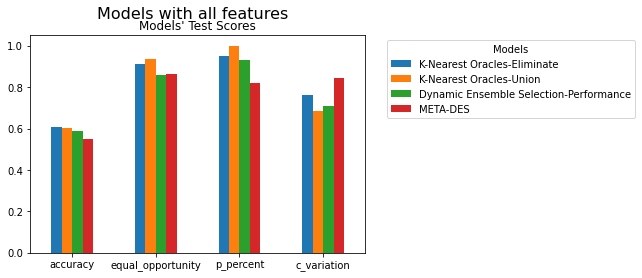

In [33]:
test_metrics_dic = {'Metric': ['accuracy','equal_opportunity','p_percent','c_variation'],
        'K-Nearest Oracles-Eliminate': [knorae.score(X_test, y_test),
                                equal_opportunity_score(sensitive_column="Sex")(knorae, X_test, y_test),
                                p_percent_score(sensitive_column="Sex")(knorae, X_test),
                                coefficient_of_variation(knorae, X_test, y_test)],
        'K-Nearest Oracles-Union': [knorau.score(X_test, y_test),
                                equal_opportunity_score(sensitive_column="Sex")(knorau, X_test, y_test),
                                p_percent_score(sensitive_column="Sex")(knorau, X_test),
                                coefficient_of_variation(knorau, X_test, y_test)],
        'Dynamic Ensemble Selection-Performance': [desp.score(X_test, y_test),
                                equal_opportunity_score(sensitive_column="Sex")(desp, X_test, y_test),
                                p_percent_score(sensitive_column="Sex")(desp, X_test),
                                coefficient_of_variation(desp, X_test, y_test)],
        'META-DES': [metades.score(X_test, y_test),
                                equal_opportunity_score(sensitive_column="Sex")(metades, X_test, y_test),
                                p_percent_score(sensitive_column="Sex")(metades, X_test),
                                coefficient_of_variation(metades, X_test, y_test)]}

test_metrics_des = pd.DataFrame(data=test_metrics_dic, 
                            columns=['Metric','K-Nearest Oracles-Eliminate','K-Nearest Oracles-Union',
                                     'Dynamic Ensemble Selection-Performance', 'META-DES'])

fig, ax = plt.subplots()

fig.suptitle('Models with all features', fontsize=16)

test_metrics_des.plot.bar(ax=ax)

ax.set_title('Models\' Test Scores')
ax.set_xticklabels(['accuracy','equal_opportunity','p_percent','c_variation'], rotation=0)
ax.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')

# Final

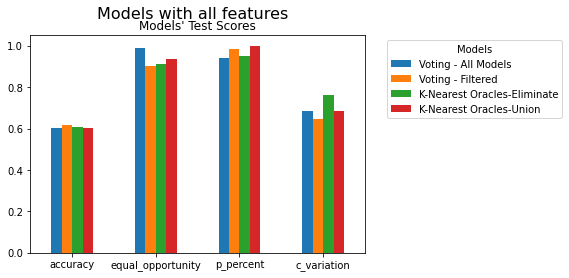

In [34]:
test_metrics_dic = {'Metric': ['accuracy','equal_opportunity','p_percent','c_variation'],
        'Voting - All Models': [eclf1.score(X_test, y_test),
                                equal_opportunity_score(sensitive_column="Sex")(eclf1, X_test, y_test),
                                p_percent_score(sensitive_column="Sex")(eclf1, X_test),
                                coefficient_of_variation(eclf1, X_test, y_test)],
        'Voting - Filtered': [eclf2.score(X_test, y_test),
                                equal_opportunity_score(sensitive_column="Sex")(eclf2, X_test, y_test),
                                p_percent_score(sensitive_column="Sex")(eclf2, X_test),
                                coefficient_of_variation(eclf2, X_test, y_test)],
        'K-Nearest Oracles-Eliminate': [knorae.score(X_test, y_test),
                                equal_opportunity_score(sensitive_column="Sex")(knorae, X_test, y_test),
                                p_percent_score(sensitive_column="Sex")(knorae, X_test),
                                coefficient_of_variation(knorae, X_test, y_test)],
        'K-Nearest Oracles-Union': [knorau.score(X_test, y_test),
                                equal_opportunity_score(sensitive_column="Sex")(knorau, X_test, y_test),
                                p_percent_score(sensitive_column="Sex")(knorau, X_test),
                                coefficient_of_variation(knorau, X_test, y_test)]}

test_metrics_des = pd.DataFrame(data=test_metrics_dic, 
                            columns=['Metric','Voting - All Models','Voting - Filtered', 
                                     'K-Nearest Oracles-Eliminate','K-Nearest Oracles-Union'])

fig, ax = plt.subplots()

fig.suptitle('Models with all features', fontsize=16)

test_metrics_des.plot.bar(ax=ax)

ax.set_title('Models\' Test Scores')
ax.set_xticklabels(['accuracy','equal_opportunity','p_percent','c_variation'], rotation=0)
ax.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')

# EqualScalarization

In [35]:
import pandas as pd

In [5]:
moo_eq = monise(weightedScalar=EqualScalarization(X_train, y_train, 'Sex'),
             singleScalar=EqualScalarization(X_train, y_train, 'Sex'),
              nodeTimeLimit=2, targetSize=150,
              targetGap=0, nodeGap=0.01, norm=False)

moo_eq.optimize()

sols_eq = []

for solution in moo_eq.solutionsList:
    sols_eq.append(solution.x)

Using license file /opt/gurobi/gurobi.lic
Academic license - for non-commercial use only


In [6]:
models_t = []
for i in range(len(sols_eq)):
    models_t.append(("Model "+str(i),sols_eq[i]))
    
eclf1_eq = SimpleVoting(estimators=models_t, voting='soft')

In [10]:
print("Metrics - Test Data")
print("Acc: ", eclf1_eq.score(X_test, y_test))
print("Eq Opor: ", equal_opportunity_score(sensitive_column="Sex")(eclf1_eq, X_test, y_test))
print("P Perc: ", p_percent_score(sensitive_column="Sex")(eclf1_eq, X_test))
print("Coev Var: ", coefficient_of_variation(eclf1_eq, X_test, y_test))

Metrics - Test Data
Acc:  0.535
Eq Opor:  1.0
P Perc:  1.0
Coev Var:  0.4814827591488293


In [7]:
# Dynamic Ensemble Selection techniques
knorau = KNORAU(sols_eq)
knorae = KNORAE(sols_eq)
desp = DESP(sols_eq)
metades = METADES(sols_eq, mode='hybrid')

# Fitting the techniques
knorau.fit(X_val, y_val)
knorae.fit(X_val, y_val)
desp.fit(X_val, y_val)
metades.fit(X_val, y_val);

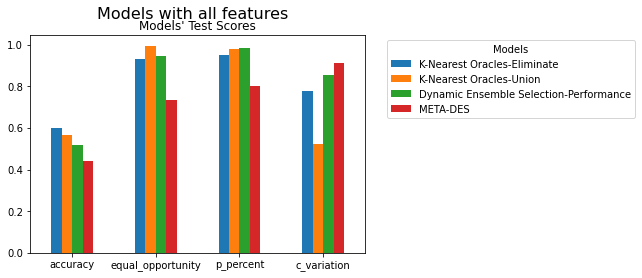

In [8]:
test_metrics_dic = {'Metric': ['accuracy','equal_opportunity','p_percent','c_variation'],
        'K-Nearest Oracles-Eliminate': [knorae.score(X_test, y_test),
                                equal_opportunity_score(sensitive_column="Sex")(knorae, X_test, y_test),
                                p_percent_score(sensitive_column="Sex")(knorae, X_test),
                                coefficient_of_variation(knorae, X_test, y_test)],
        'K-Nearest Oracles-Union': [knorau.score(X_test, y_test),
                                equal_opportunity_score(sensitive_column="Sex")(knorau, X_test, y_test),
                                p_percent_score(sensitive_column="Sex")(knorau, X_test),
                                coefficient_of_variation(knorau, X_test, y_test)],
        'Dynamic Ensemble Selection-Performance': [desp.score(X_test, y_test),
                                equal_opportunity_score(sensitive_column="Sex")(desp, X_test, y_test),
                                p_percent_score(sensitive_column="Sex")(desp, X_test),
                                coefficient_of_variation(desp, X_test, y_test)],
        'META-DES': [metades.score(X_test, y_test),
                                equal_opportunity_score(sensitive_column="Sex")(metades, X_test, y_test),
                                p_percent_score(sensitive_column="Sex")(metades, X_test),
                                coefficient_of_variation(metades, X_test, y_test)]}

test_metrics_des = pd.DataFrame(data=test_metrics_dic, 
                            columns=['Metric','K-Nearest Oracles-Eliminate','K-Nearest Oracles-Union',
                                     'Dynamic Ensemble Selection-Performance', 'META-DES'])

fig, ax = plt.subplots()

fig.suptitle('Models with all features', fontsize=16)

test_metrics_des.plot.bar(ax=ax)

ax.set_title('Models\' Test Scores')
ax.set_xticklabels(['accuracy','equal_opportunity','p_percent','c_variation'], rotation=0)
ax.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')